# Data Exploration Iteration 2

Since the outcomes of the model defined in <b>USAccidents_model_def_train_evaluate1.0.ipynb</b> were not convincing, a deeper dive into the time progression of the data willbe made, in order to understand why the models are giving the one-hot encoding of variable 'Year_2020' such a great prediction importance.

## Plot Time Progression of Severity

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import original version of data

df = pd.read_csv('US_Accidents_June20.csv', index_col=False)
print('df.columns.shape:', df.columns.shape)
print('df.columns:', df.columns)

df.columns.shape: (49,)
df.columns: Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


Looks like the data was correctly imported!

In [3]:
#As in the original dataset, typecast dates and timestamps to datetime format

df['Start_Time'] = pd.to_datetime(df.Start_Time, format='%Y-%m-%d %H:%M:%S')
df['End_Time'] = pd.to_datetime(df.End_Time, format='%Y-%m-%d %H:%M:%S')
df['Weather_Timestamp'] = pd.to_datetime(df.Weather_Timestamp, format='%Y-%m-%d %H:%M:%S')

In [4]:
#Divide timestamps in Year, Month, Weekday, Day, Hour, Minute
#Year
df['Year'] = df['Start_Time'].dt.year

#Month
n_month = df['Start_Time'].dt.month
df['Month'] = n_month

#Weekday
df['Weekday']= df['Start_Time'].dt.weekday

#Day as number between 1-365
days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
nday = [days_each_month[arg-1] for arg in n_month.values]
nday = nday + df["Start_Time"].dt.day.values
df['Day'] = nday

#Hour
df['Hour'] = df['Start_Time'].dt.hour

#Minute
df['Minute']=df['Hour']*60.0+df["Start_Time"].dt.minute

print('Number of features after feature creation:', df.columns.shape[0])
print()

df.loc[:5, ['Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']]

Number of features after feature creation: 55



,Year,Month,Weekday,Day,Hour,Minute
0,2016,2,0,39,5,346.0
1,2016,2,0,39,6,367.0
2,2016,2,0,39,6,409.0
3,2016,2,0,39,7,443.0
4,2016,2,0,39,7,459.0
5,2016,2,0,39,7,464.0


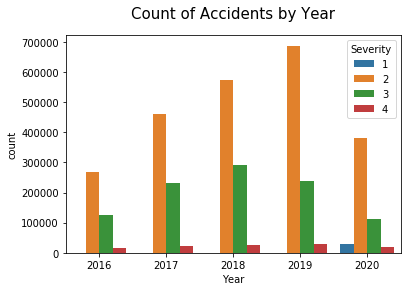

In [5]:
# plot severity time progression
df.Year = df.Year.astype(str)

sns.countplot(x='Year', hue='Severity', data=df)
plt.title('Count of Accidents by Year', size=15, y=1.05)
plt.show()

It looks like there are almost no Severity 1 accidents. For the rest of accidents, we have to notice that for 2020 we are only counting the accidents until June, so the amount of accidents and its distribution looks reasonable. Let's look again at how the severity is defined.<br><br>

Looking at the source of the data, we find it. <br>
<b>Severity:</b> 'Shows the severity of the accident, a number between 1 and 4, where 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay).'<br>
So the two most important columns for Severity should be <b>Duration</b> (as defined in the USAccidents_data_exp1.0.ipynb) and <b>Distance</b> ('The length of the road extent affected by the accident').

## Plot Severity against Duration and Distance

In [6]:
#Define Duration as in USAccidents_model_data_exp1.0.ipynb
start_time_vec = df['Start_Time']
end_time_vec = df['End_Time']

df['Duration'] = (end_time_vec-start_time_vec).astype('timedelta64[m]')

In [7]:
df.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Year', 'Month', 'Weekday', 'Day', 'Hour',
       'Minute', 'Duration'],
      dtype='object')

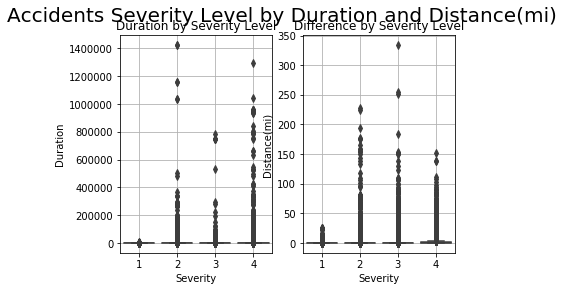

In [8]:
fig, axes = plt.subplots(ncols=2)
plt.title('Accidents Severity Level by Duration and Distance(mi)', fontsize=20)

sns.boxplot(x="Severity", y="Duration", data=df, ax=axes[0])
axes[0].set_title('Duration by Severity Level')

sns.boxplot(x="Severity", y="Distance(mi)", data=df, ax=axes[1])
axes[1].set_title('Difference by Severity Level')

plt.suptitle('Accidents Severity Level by Duration and Distance(mi)', fontsize=20)
axes[0].grid(True)
axes[1].grid(True)
plt.show()

There are outliers that prevent the boxplot from being readable. I'll get rid of those outliers and replot.

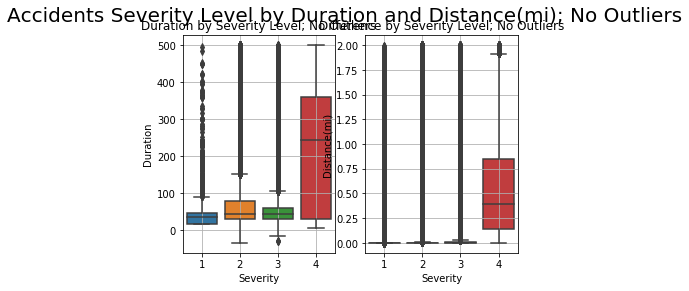

In [9]:
fig, axes = plt.subplots(ncols=2)

sns.boxplot(x="Severity", y="Duration", data=df.loc[df['Duration']<500], ax=axes[0])
axes[0].set_title('Duration by Severity Level; No Outliers')

sns.boxplot(x="Severity", y="Distance(mi)", data=df.loc[df['Distance(mi)']<2], ax=axes[1])
axes[1].set_title('Difference by Severity Level; No Outliers')

plt.suptitle('Accidents Severity Level by Duration and Distance(mi); No Outliers', fontsize=20)
axes[0].grid(True)
axes[1].grid(True)
plt.show()

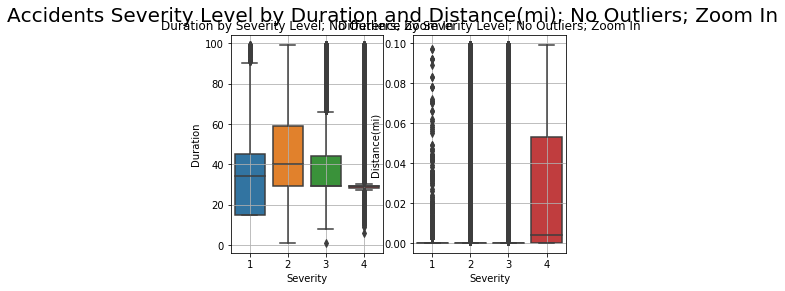

In [10]:
fig, axes = plt.subplots(ncols=2)

sns.boxplot(x="Severity", y="Duration", data=df.loc[(df['Duration']<100) & (df['Duration']>0)], ax=axes[0])
axes[0].set_title('Duration by Severity Level; No Outliers; Zoom In')

sns.boxplot(x="Severity", y="Distance(mi)", data=df.loc[df['Distance(mi)']<0.1], ax=axes[1])
axes[1].set_title('Difference by Severity Level; No Outliers; Zoom In')

plt.suptitle('Accidents Severity Level by Duration and Distance(mi); No Outliers; Zoom In', fontsize=20)
axes[0].grid(True)
axes[1].grid(True)
plt.show()

We can see that the Severity levels overlap in terms of <b>Duration</b> of the accidents. For such a case, it makes sense that out model was only capable of predicting with an accuracy of around 80% on the validation dataset.<br>

Additionally, in terms of <b>Distance(mi)</b> there is a clear difference between the accidents that were catalogued as Severity level 4 and the ones that qualified for Severity levels 1-3.

The next step will be to find out what could be the cause of that overlap between severity levels.

## Severity against Data Source

In the begining of the project I mentioned that the traffic accident data came from 3 different sources: <b>MapQuest</b>, <b>Bing</b> and <b>MapQuest-Bing</b>. I'll look at how severity levels are defined for each specific datasource.

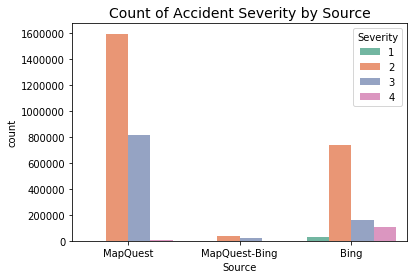

In [11]:
# plot severity time progression

sns.countplot(x='Source', hue='Severity', data=df ,palette="Set2")
plt.title('Count of Accident Severity by Source', size=14)
plt.show()

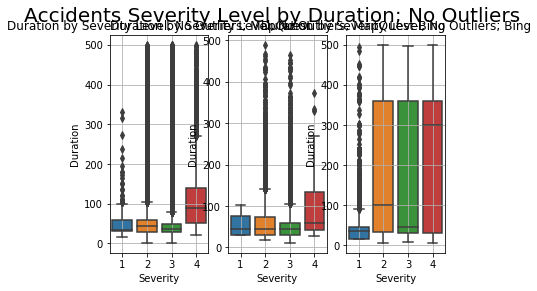

In [12]:
fig, axes = plt.subplots(ncols=3)

sns.boxplot(x="Severity", y="Duration", data=df.loc[(df['Duration']<500) & (df['Duration']>0) & (df['Source']=='MapQuest')], ax=axes[0])
axes[0].set_title('Duration by Severity Level; No Outliers; MapQuest')

sns.boxplot(x="Severity", y="Duration", data=df.loc[(df['Duration']<500) & (df['Duration']>0) & (df['Source']=='MapQuest-Bing')], ax=axes[1])
axes[1].set_title('Duration by Severity Level; No Outliers; MapQuest-Bing')

sns.boxplot(x="Severity", y="Duration", data=df.loc[(df['Duration']<500) & (df['Duration']>0) & (df['Source']=='Bing')], ax=axes[2])
axes[2].set_title('Duration by Severity Level; No Outliers; Bing')

plt.suptitle('Accidents Severity Level by Duration; No Outliers', fontsize=20)
axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
plt.show()

It looks like the spread in <b>Duration</b> is much higher for the data from 'Source' <b>Bing</b> than for <b>MapQuest</b> and <b>MapQuest-Bing</b>.

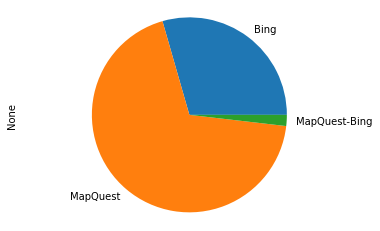

In [14]:
#Plot pie diagram
df_groupby_source = df.groupby('Source').size()

fig, ax = plt.subplots()
df_groupby_source.plot.pie(subplots=True,figsize=(8, 3))
ax.axis('equal')

plt.show()

Since the amount of data provenient from Source <b>Bing</b> notably less than for the other 2 (below 30% of the data) and I was sampling from the data in order to deal with class imbalance, I'll look at how the model performances are impacted if only looking at that data from the other 2 datasources: <b>MapQuest</b> and <b>MapQuest-Bong</b>

In [15]:
## Save data without Source==Bing
df = df.loc[(df['Source']=='MapQuest') | (df['Source']=='MapQuest-Bing')]
print(df.shape)

(2478818, 56)


## Export df

In [17]:
df.to_csv('US_Accidents_June20_CLEAN_Week1_Iteration2.0.csv', index=False)